# Flight Price Prediction

## Problem Statement

Flight ticket prices can be something hard to guess, today we might see a price, check out the price of the same flight tomorrow, and it will be a different story.
To solve this problem, we have been provided with prices of flight tickets for various airlines between the months of October and December of 2021 and between various cities, using which we aim to build a model which predicts the prices of the flights using various input features.

### Importing Libraries

In [1]:
import pandas as pd # for handling dataset
import numpy as np  # for mathematical computation

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew

# for visualization 
import plotly.express as px
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
import seaborn as sns

# for saving & loading model
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Web scrapping was done from yatra website from October to December month of year 2021. 
# The data for price was further corrected by removing semicolon from it by using flash fill in excel sheet.
# Example : 5,953 to 5953 and rest for all others.

In [3]:
# reading the data
df=pd.read_csv(r'E:\webscraped_data.csv')

In [4]:
df.head() # to display top 5 rows from dataset

,Airline,Date_of_Journey,Source,Destination,Duration,Departure Time,Arrival Time,Total Stops,Price
0,Air Asia,29-10-2021,New Delhi,Mumbai,6h 35m,09:25,16:00,1 Stop,5953
1,Air Asia,29-10-2021,New Delhi,Mumbai,7h 35m,12:40,20:15,1 Stop,5953
2,Air Asia,29-10-2021,New Delhi,Mumbai,8h 20m,11:55,20:15,1 Stop,5953
3,Air Asia,29-10-2021,New Delhi,Mumbai,14h 55m,05:20,20:15,1 Stop,5953
4,Go First,29-10-2021,New Delhi,Mumbai,1h 55m,18:50,20:45,Non Stop,5954


#### Dataset Description

1. Airline - Names of different flights/Airlines 

2. Date of Journey - Day on which journey begins (i.e to travel by flight)

3. Source - City from where flight takes off 

4. Destination - City where flight lands

5. Duration - Total time taken by flight to reach its destination (in hrs mins)

6. Departure time - Time when flight takes off

7. Arrival Time - Time when flight lands

8. Total Stops - Number of stoppages

9. Price - Flight ticket price (in inr)

In [5]:
print('Total no of rows & columns: ',df.shape) # to check number of rows & columns

Total no of rows & columns:  (1588, 9)


In [6]:
print('List of columns: ',df.columns) # to display all the columns name in the dataset

List of columns:  Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Duration',
       'Departure Time', 'Arrival Time', 'Total Stops', 'Price'],
      dtype='object')


In [7]:
df.info() # to know datatype of each columns 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1588 entries, 0 to 1587
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          1588 non-null   object
 1   Date_of_Journey  1588 non-null   object
 2   Source           1588 non-null   object
 3   Destination      1588 non-null   object
 4   Duration         1588 non-null   object
 5   Departure Time   1588 non-null   object
 6   Arrival Time     1588 non-null   object
 7   Total Stops      1588 non-null   object
 8   Price            1588 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 111.8+ KB


In [8]:
# to count number of unique values in each columns 
df.nunique()

Airline              6
Date_of_Journey     13
Source              13
Destination          8
Duration           315
Departure Time     238
Arrival Time       331
Total Stops          4
Price              687
dtype: int64

In [9]:
# to list categorical features in our dataset
cat_features=[i for i in df.columns if df.dtypes[i]=='object']
cat_features

['Airline',
 'Date_of_Journey',
 'Source',
 'Destination',
 'Duration',
 'Departure Time',
 'Arrival Time',
 'Total Stops']

In [10]:
# to list continous features in our dataset
con_features=[i for i in df.columns if df.dtypes[i]=='int64' or df.dtypes[i]=='float64']
con_features

['Price']

In [11]:
df.describe().T # to get high understanding of dataset or to get overview/stats of the dataset

,count,mean,std,min,25%,50%,75%,max
Price,1588.0,9703.163098,4234.597613,2346.0,6777.5,8989.5,11657.0,31818.0


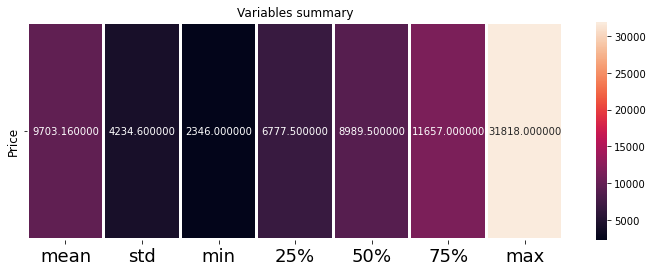

In [12]:
plt.figure(figsize=(12,4))
sns.heatmap(round(df.describe()[1:].transpose(),2),linewidth=2,annot=True,fmt='f')
plt.xticks(fontsize=18)
plt.yticks(fontsize=12)
plt.title("Variables summary")
plt.show()

In [13]:
df.isnull().sum()  # to check null values

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Duration           0
Departure Time     0
Arrival Time       0
Total Stops        0
Price              0
dtype: int64

#### No null values in the dataset

In [14]:
# to check format of date of journey
df['Date_of_Journey'].unique()

array(['29-10-2021', '30-10-2021', '31-10-2021', '02-11-2021',
       '05-11-2021', '08-11-2021', '11-11-2021', '10-11-2021',
       '27-11-2021', '29-11-2021', '13-12-2021', '10-12-2021',
       '30-12-2021'], dtype=object)

#### From the above output column we know that Date_of_Journey is a object data type.

In [15]:
# Converting Date_of_Journey format into timestamp so as to use this column properly for prediction.
df['Date_of_Journey']=df['Date_of_Journey'].replace('29-10-2021','29/10/2021',regex=True)
df['Date_of_Journey']=df['Date_of_Journey'].replace('30-10-2021','30/10/2021',regex=True)
df['Date_of_Journey']=df['Date_of_Journey'].replace('31-10-2021','31/10/2021',regex=True)
df['Date_of_Journey']=df['Date_of_Journey'].replace('02-11-2021','02/11/2021',regex=True)
df['Date_of_Journey']=df['Date_of_Journey'].replace('05-11-2021','05/11/2021',regex=True)
df['Date_of_Journey']=df['Date_of_Journey'].replace('08-11-2021','08/11/2021',regex=True)
df['Date_of_Journey']=df['Date_of_Journey'].replace('11-11-2021','11/11/2021',regex=True)
df['Date_of_Journey']=df['Date_of_Journey'].replace('10-11-2021','10/11/2021',regex=True)
df['Date_of_Journey']=df['Date_of_Journey'].replace('27-11-2021','27/11/2021',regex=True)
df['Date_of_Journey']=df['Date_of_Journey'].replace('29-11-2021','29/11/2021',regex=True)
df['Date_of_Journey']=df['Date_of_Journey'].replace('13-12-2021','13/12/2021',regex=True)
df['Date_of_Journey']=df['Date_of_Journey'].replace('10-12-2021','10/12/2021',regex=True)
df['Date_of_Journey']=df['Date_of_Journey'].replace('30-12-2021','30/12/2021',regex=True)

In [16]:
# checking the format again
df['Date_of_Journey'].unique()

array(['29/10/2021', '30/10/2021', '31/10/2021', '02/11/2021',
       '05/11/2021', '08/11/2021', '11/11/2021', '10/11/2021',
       '27/11/2021', '29/11/2021', '13/12/2021', '10/12/2021',
       '30/12/2021'], dtype=object)

In [17]:
# converting object data type to datetime object.
df['Journey_Day'] = pd.to_datetime(df.Date_of_Journey, format="%d/%m/%Y").dt.day
df['Journey_Month'] = pd.to_datetime(df["Date_of_Journey"], format="%d/%m/%Y").dt.month

In [18]:
# dropping the original column
df=df.drop(columns='Date_of_Journey')

In [19]:
# Extracting the hours and minutes from departure time column and afterwards we will drop the original column.
df["Dep_hour"] = pd.to_datetime(df['Departure Time']).dt.hour
df['Dep_min'] = pd.to_datetime(df['Departure Time']).dt.minute
df.drop(columns=['Departure Time'],inplace=True)

In [20]:
# Extracting the hours and minutes from Arrival time column and afterwards we will drop the original column.
df["Arrival_hour"] = pd.to_datetime(df['Arrival Time']).dt.hour
df['Arrival_min'] = pd.to_datetime(df['Arrival Time']).dt.minute
df.drop(columns=['Arrival Time'],inplace=True)

In [21]:
# Feature engineering on Duration column

Duration = list(df['Duration'])

for i in range(len(Duration)):
    if len(Duration[i].split()) != 2:
        if "h" in Duration[i]:
            Duration[i] = Duration[i].strip() + " 0m"
        else:
            Duration[i] = "0h " + Duration[i]

Duration_hours = []
Duration_mins = []

for i in range(len(Duration)):
    Duration_hours.append(int(Duration[i].split(sep='h')[0]))
    Duration_mins.append(int(Duration[i].split(sep='m')[0].split()[-1]))

In [22]:
# Storing the hours and minutes into dataframe and afterwards we will remove the original column.
df['Duration_hours'] = Duration_hours
df['Duration_mins'] = Duration_mins
df.drop(columns=['Duration'],inplace=True)

In [23]:
# categorizing hours into times of day
def tod(x):                    # defining function times of day as tod
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Evening'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'

In [24]:
# applying the condition 
df['Arrival_Times_of_day']=df['Arrival_hour'].apply(tod)
df.drop(['Arrival_hour'],axis=1,inplace=True)

In [25]:
# checking after categorizing
df['Arrival_Times_of_day'].unique()

array(['Noon', 'Evening', 'Morning', 'Early Morning', 'Night',
       'Late Night'], dtype=object)

In [26]:
# to know all type of unique values present in the column
df['Journey_Month'].unique()

array([10, 11, 12], dtype=int64)

In [27]:
# categorizing months into object
def month(x):                    # defining function Journey month as month
    if (x==10):
        return 'October'
    elif (x==11 ):
        return 'November'
    elif (x==12):
        return'December'

In [28]:
# applying the condition 
df['Journey Month']=df['Journey_Month'].apply(month)
df.drop(['Journey_Month'],axis=1,inplace=True)

In [29]:
# checking after categorizing
df['Journey Month'].unique()

array(['October', 'November', 'December'], dtype=object)

## Univariate Analysis

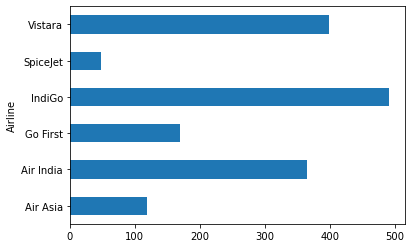

In [30]:
# to visualize 'Airline' column
df.groupby('Airline')['Airline'].count().plot(kind='barh')
plt.show()

#### Indigo flights will be available more from Oct-Dec month and Spicejet flights would be less available.

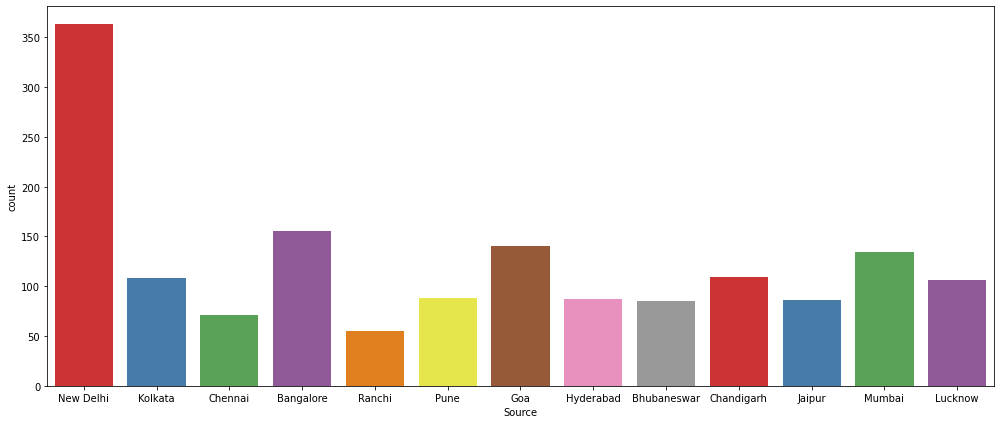

In [31]:
# to visualize Source column
plt.figure(figsize=(14,6))
sns.countplot('Source',data=df,palette='Set1')
plt.tight_layout()

#### Mostly flights will take off from New Delhi and least from Ranchi in Oct-Dec month according to the data scraped.

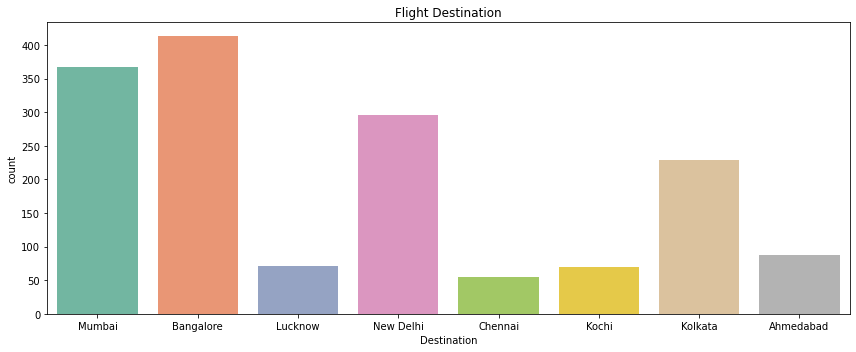

In [32]:
# to visualize Destination column
plt.figure(figsize=(12,5))
sns.countplot('Destination',data=df,palette='Set2')
plt.title('Flight Destination')
plt.tight_layout()

#### Maximum flights will land at Bangalore and least flights will land at Chennai according to the data scraped.

Text(0.5, 0, 'Number of Stoppages')

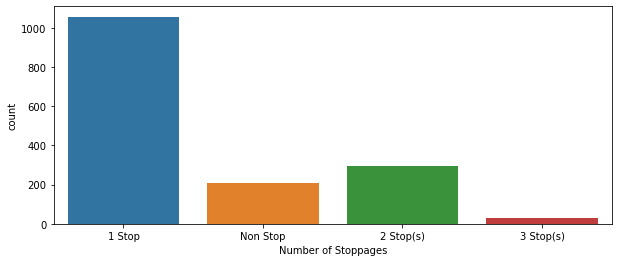

In [33]:
# to visualize the Total Stoppage column 
plt.figure(figsize=(10,4))
sns.countplot(x='Total Stops',data=df)
plt.xlabel('Number of Stoppages')

#### Maximum number of stoppages is only one for various routes(i.e source-destination).

## Bivariate Analysis

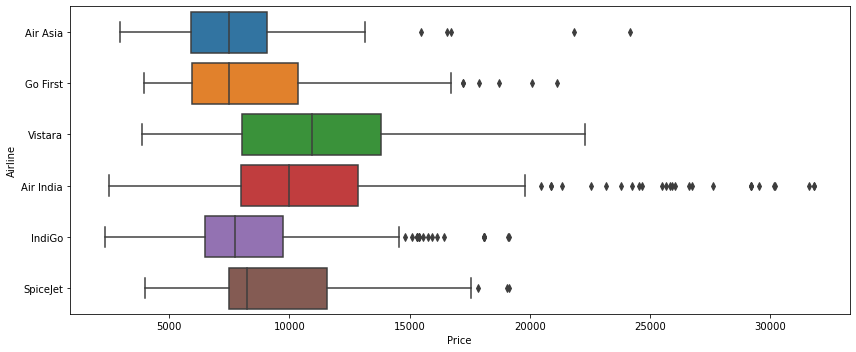

In [35]:
plt.figure(figsize=(12,5))
sns.boxplot(y='Airline', x='Price',data=df)
plt.tight_layout()

#### Air India flight price is costlier than other airlines for month of Oct-Dec 2021.

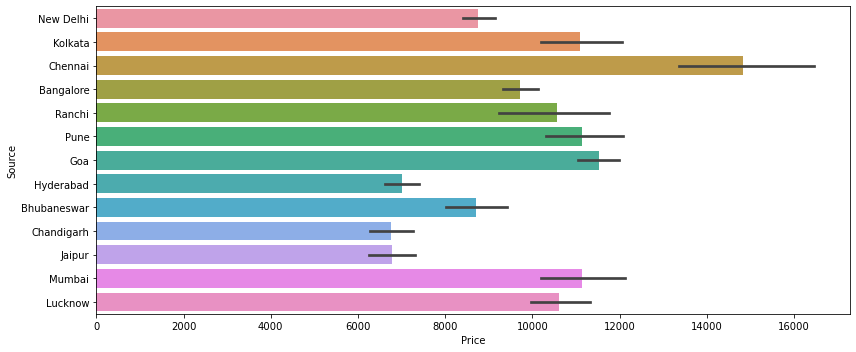

In [36]:
plt.figure(figsize=(12,5))
sns.barplot(y='Source', x='Price',data=df)
plt.tight_layout()

#### The price of flight ticket from Chennai is much high than other cities.

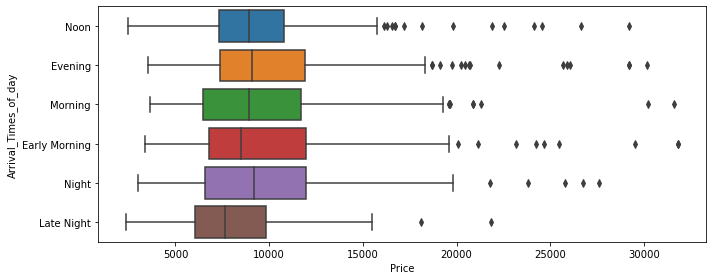

In [37]:
# to visualize 'Arrival_Times_of_day' vs 'Price'
plt.figure(figsize=(10,4))
sns.boxplot(y='Arrival_Times_of_day',x='Price',data=df)
plt.tight_layout()

#### Price of flight ticket in evening & early morning is costlier and cheap in night when boarding to destination.

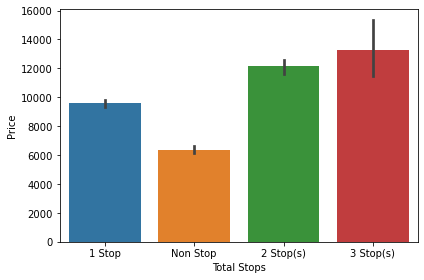

In [38]:
# to visualize 'Total Stops' vs 'Price'
sns.barplot(x='Total Stops',y='Price',data=df)
plt.tight_layout()

#### Price of flight ticket increases with increase in number of stoppages. 

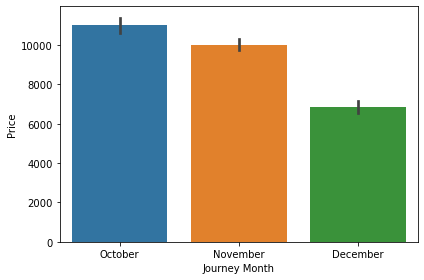

In [39]:
# to visualize 'Total Stops' vs 'Price'
sns.barplot(x='Journey Month',y='Price',data=df)
plt.tight_layout()

#### Price of flight ticket decreases with increase in month (i.e You will get ticket at low cost price if you book your ticket earlier)

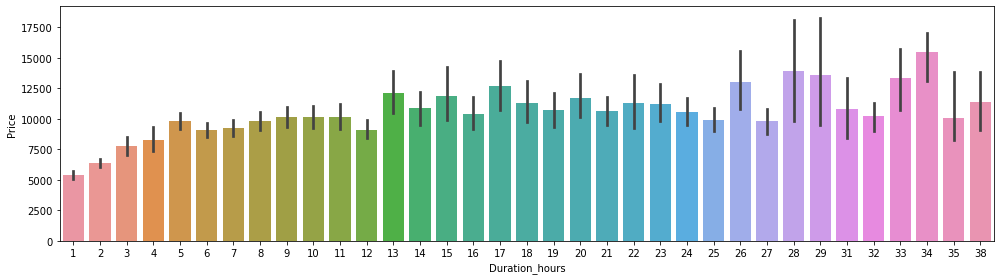

In [40]:
# to visualize 'Duration hours' vs 'Price'
plt.figure(figsize=(14,4))
sns.barplot(x='Duration_hours',y='Price',data=df)
plt.tight_layout()

#### Maximum the duration of time taken by the flight to reach its destination , higher will be the ticket price.

In [42]:
last_column = df.pop('Price')
df.insert(12, 'Price', last_column)  # inserting price at the last column as its our target/label

In [43]:
df.head()

,Airline,Source,Destination,Total Stops,Journey_Day,Dep_hour,Dep_min,Arrival_min,Duration_hours,Duration_mins,Arrival_Times_of_day,Journey Month,Price
0,Air Asia,New Delhi,Mumbai,1 Stop,29,9,25,0,6,35,Noon,October,5953
1,Air Asia,New Delhi,Mumbai,1 Stop,29,12,40,15,7,35,Evening,October,5953
2,Air Asia,New Delhi,Mumbai,1 Stop,29,11,55,15,8,20,Evening,October,5953
3,Air Asia,New Delhi,Mumbai,1 Stop,29,5,20,15,14,55,Evening,October,5953
4,Go First,New Delhi,Mumbai,Non Stop,29,18,50,45,1,55,Evening,October,5954


In [44]:
from sklearn.preprocessing import LabelEncoder

In [45]:
# converting objects into integers of data
lab_enc = LabelEncoder()
list1 = ['Airline', 'Source', 'Destination','Total Stops','Arrival_Times_of_day','Journey Month']
for val in list1:
    df[val] = lab_enc.fit_transform(df[val].astype(str))

In [46]:
# checking if all features has transformed into machine language
df.head()

,Airline,Source,Destination,Total Stops,Journey_Day,Dep_hour,Dep_min,Arrival_min,Duration_hours,Duration_mins,Arrival_Times_of_day,Journey Month,Price
0,0,10,6,0,29,9,25,0,6,35,5,2,5953
1,0,10,6,0,29,12,40,15,7,35,1,2,5953
2,0,10,6,0,29,11,55,15,8,20,1,2,5953
3,0,10,6,0,29,5,20,15,14,55,1,2,5953
4,2,10,6,3,29,18,50,45,1,55,1,2,5954


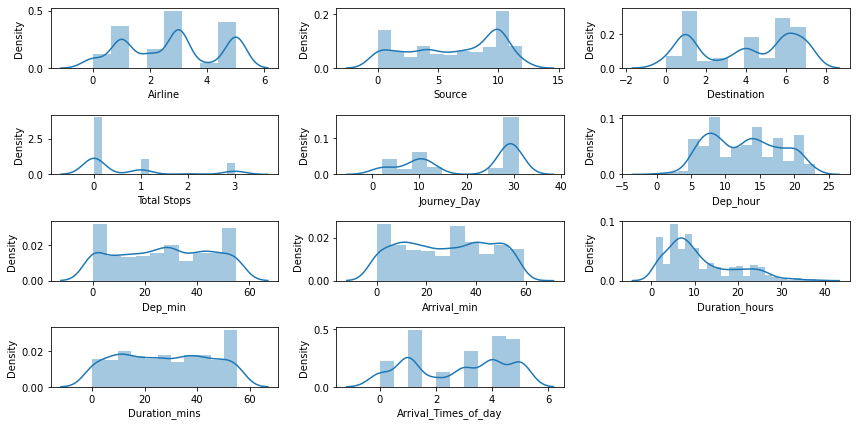

In [48]:
# to visualize columns
plt.figure(figsize=(12,6), facecolor='white')
plotnumber=1
for column in df:
    if plotnumber<=11:
        ax=plt.subplot(4,3,plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column,fontsize=10)
    plotnumber+=1
plt.tight_layout()

#### Skewness can be seen in Duration hour feature

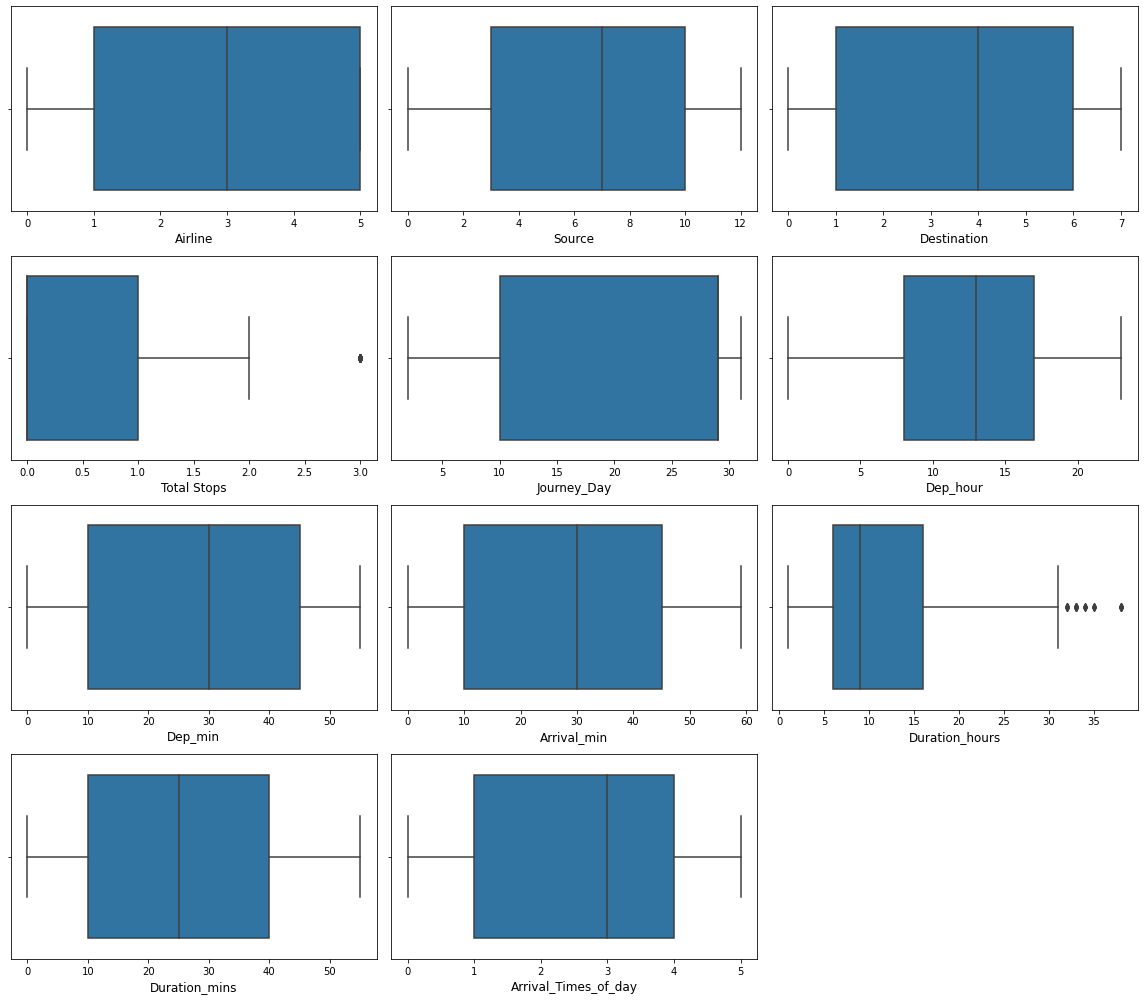

In [49]:
# Lets visualize the columns in boxplot to check outliers
plt.figure(figsize=(16,14))
plot=1
for col in df:
    if plot<=11:
        plt.subplot(4,3,plot)
        sns.boxplot(df[col])
        plt.xlabel(col,fontsize=12)
        plot=plot+1
plt.tight_layout()

In [50]:
# Using 1.5 IQR method to remove outliers

def outlier(df,col):
    lower_boundary=df[col].mean()-1.5*df[col].std()
    upper_boundary=df[col].mean()+1.5*df[col].std()
    print(lower_boundary,upper_boundary)
    df.loc[df[col]> upper_boundary,col] = upper_boundary
    df.loc[df[col]<lower_boundary,col]=lower_boundary

In [51]:
outlier(df,'Duration_hours')

-0.6318867322297272 22.974456001751136


<AxesSubplot:xlabel='Duration_hours'>

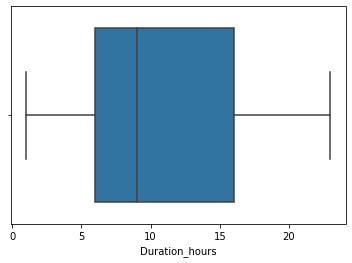

In [52]:
# After removal of outlier
sns.boxplot(df['Duration_hours'])

In [53]:
# to see skewness for every column stored in the data
for col in df:
    print(col)
    print(skew(df[col]))

Airline
0.03392505793867277
Source
-0.33145398295922995
Destination
-0.2071313242584327
Total Stops
1.5474184224645302
Journey_Day
-0.39376559715926607
Dep_hour
0.11962093693899582
Dep_min
-0.03588100969534525
Arrival_min
-0.020597133245571688
Duration_hours
0.585954945958042
Duration_mins
0.028652769366026384
Arrival_Times_of_day
-0.15201286719447926
Journey Month
-0.2434539313214375
Price
1.477225966050321


In [54]:
# Applying log transformation to remove skewness
for col in df.columns:
    if df.skew().loc[col]>0.55:
        df[col]=np.log1p(df[col])

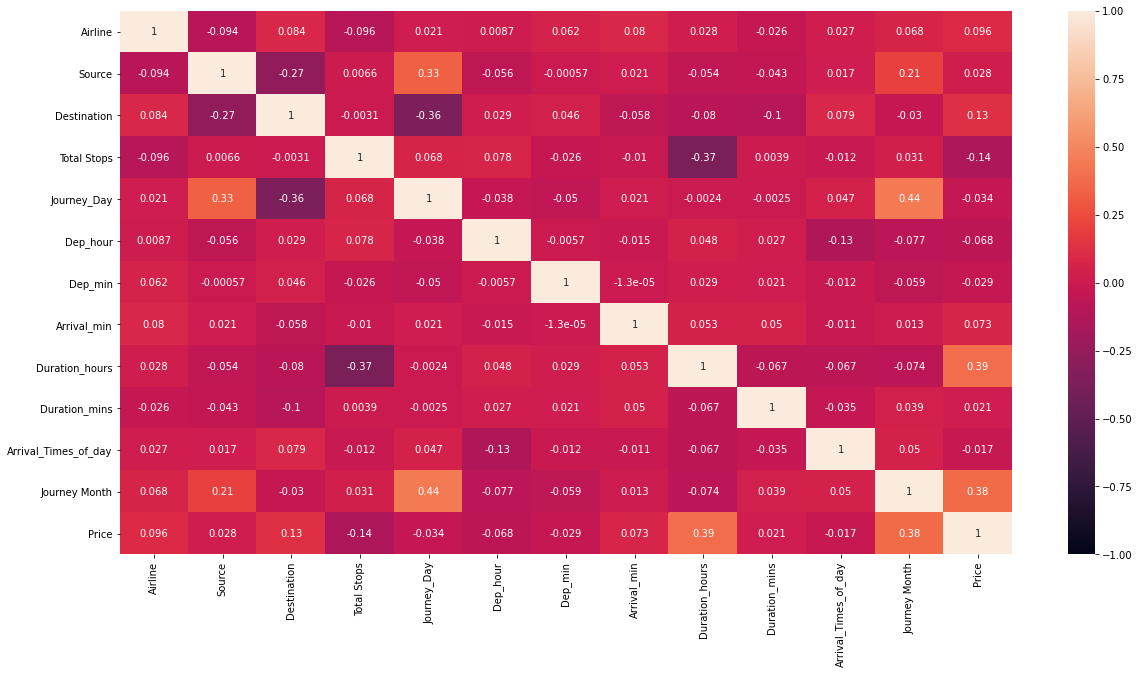

In [55]:
# plotting heatmap to observe the correlation
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True, vmin=-1.0, vmax=1.0)
plt.show()

#### Duration hour and Journey Month are positively correlated with the target (price) variable.

In [56]:
y = df['Price']
X = df.drop('Price', axis = 1)

In [57]:
# Data Scaling.  Formula Z=(x-mean)/std
scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

In [58]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(X_scaled, i) for i in range (X_scaled.shape[1])]
vif["features"] = X.columns

#let's check the values
vif

,vif,features
0,1.047168,Airline
1,1.197943,Source
2,1.274826,Destination
3,1.196194,Total Stops
4,1.548096,Journey_Day
5,1.038001,Dep_hour
6,1.013190,Dep_min
7,1.016651,Arrival_min
8,1.208199,Duration_hours
9,1.034864,Duration_mins


#### No Multicollinearity problem exists

In [91]:
# Split data into train and test. Model will be built on training data and tested on test data
x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size = 0.25, random_state = 42)

In [92]:
y_train.head()

1285    9.219498
602     9.519368
483     9.689861
1286    9.364520
1009    9.802838
Name: Price, dtype: float64

## Linear Regression

In [93]:
regression = LinearRegression()
regression.fit(x_train,y_train)

LinearRegression()

In [94]:
# Adjusted R2 score
regression.score(x_train,y_train)

0.3977709722263013

In [95]:
# To cross verify
y_pred = regression.predict(x_test)

In [96]:
r2_score(y_test,y_pred)

0.3904844364494573

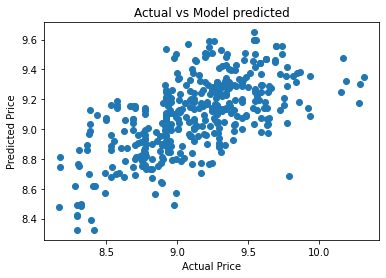

In [97]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Model predicted')
plt.show()

In [98]:
mean_absolute_error(y_test,y_pred)

0.23917585268941327

In [99]:
mean_squared_error(y_test,y_pred)

0.09714120762159414

In [100]:
np.sqrt(mean_squared_error(y_test,y_pred))

0.31167484277944885

In [101]:
# Cross Validation score to check if the model is overfitting or underfitting
score= cross_val_score(regression,X_scaled,y,cv=5)
print(score)
print(score.mean())
print(score.std())

[ 1.19564129e-01  1.74970512e-01  1.59102243e-01 -1.47076843e-04
  3.29193160e-01]
0.15653659330936068
0.10589940271081685


## Using Regularization method to check whether our regression model is overfitting or not

In [102]:
from sklearn.linear_model import Ridge,Lasso,RidgeCV,LassoCV

### Lasso Regularization

In [103]:
# LassoCV will return best alpha after max iteration
# Normalize is subtracting the mean and dividingby the l2-norm
lasscv = LassoCV(alphas = None, max_iter = 1000, normalize = True)
lasscv.fit(x_train,y_train)

LassoCV(normalize=True)

In [104]:
# best alpha parameter
alpha = lasscv.alpha_
alpha

1.19660008888917e-05

In [105]:
# now that we have best parameter, lets use Lasso regression and see how well our data has fitted before
lasso_reg = Lasso(alpha)
lasso_reg.fit(x_train,y_train)

Lasso(alpha=1.19660008888917e-05)

In [106]:
lasso_reg.score(x_test,y_test)

0.39049714890472176

### Using Ridge regression model

In [107]:
# RidgeCV will return best alpha and coefficients after performing 10 cross validations.
ridgecv = RidgeCV(alphas = np.arange(0.001,0.1,0.01),normalize = True)
ridgecv.fit(x_train,y_train)

RidgeCV(alphas=array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091]),
        normalize=True)

In [108]:
ridgecv.alpha_

0.011

In [109]:
ridge_model = Ridge(alpha=ridgecv.alpha_)
ridge_model.fit(x_train,y_train)

Ridge(alpha=0.011)

In [110]:
ridge_model.score(x_test,y_test)

0.3904846727571981

#### So we can see by using different type of regularization,we still are getting almost same r2 score. That means our linear regression model has been well trained over the training data and there is no overfitting.

## Decision Tree Regressor

In [111]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(x_train,y_train)

print("\n===================Train Result======================")

print(f"Accuracy Score: {dt_reg.score(x_train,y_train) * 100:.2f}%")
print("______________________________________________")

#*********************** Test Score *************************

y_pred = dt_reg.predict(x_test)
print("\n===================Test Result======================")
print(f"Accuracy Score: {dt_reg.score(x_test,y_test) * 100:.2f}%")
print("______________________________________________")


===================Train Result======================
Accuracy Score: 99.95%
______________________________________________

===================Test Result======================
Accuracy Score: 39.53%
______________________________________________


In [112]:
# Cross Validation score to check if the model is overfitting or underfitting
score= cross_val_score(dt_reg,X_scaled,y,cv=5)
print(score)
print(score.mean())
print(score.std())

[-0.86308696 -0.5923403  -1.0714415  -1.18926873 -0.07787534]
-0.758802565064294
0.39630569699335005


## Random Forest Regressor

In [113]:
rand_reg = RandomForestRegressor(n_estimators = 100,random_state=51)
rand_reg.fit(x_train,y_train)

print("\n===================Train Result======================")

print(f"Accuracy Score: {rand_reg.score(x_train,y_train) * 100:.2f}%")
print("______________________________________________")

#*********************** Test Score *************************

y_pred = rand_reg.predict(x_test)
print("\n===================Test Result======================")
print(f"Accuracy Score: {rand_reg.score(x_test,y_test) * 100:.2f}%")
print("______________________________________________")


===================Train Result======================
Accuracy Score: 95.11%
______________________________________________

===================Test Result======================
Accuracy Score: 68.96%
______________________________________________


In [114]:
# Cross Validation score to check if the model is overfitting or underfitting
score= cross_val_score(rand_reg,X_scaled,y,cv=5)
print(score)
print(score.mean())
print(score.std())

[-0.33042593  0.20671447 -0.26973551 -0.36015241  0.28336856]
-0.09404616688341405
0.2794471342471171


## KNN Regressor

In [115]:
knn=KNeighborsRegressor(n_neighbors=3)
knn.fit(x_train,y_train)

print("\n===================Train Result======================")

print(f"Accuracy Score: {knn.score(x_train,y_train) * 100:.2f}%")
print("______________________________________________")

#*********************** Test Score *************************

y_pred = knn.predict(x_test)
print("\n===================Test Result======================")
print(f"Accuracy Score: {knn.score(x_test,y_test) * 100:.2f}%")
print("______________________________________________")


===================Train Result======================
Accuracy Score: 71.69%
______________________________________________

===================Test Result======================
Accuracy Score: 46.29%
______________________________________________


In [116]:
# Cross Validation score to check if the model is overfitting or underfitting
score= cross_val_score(knn,X_scaled,y,cv=5)
print(score)
print(score.mean())
print(score.std())

[ 0.24444226 -0.19655631 -0.60951529 -1.35879754 -0.03155223]
-0.3903958227196737
0.557705497703838


## Gradient Boosting Regressor

In [117]:
from sklearn.ensemble import GradientBoostingRegressor
np.random.seed(42)
gbr = GradientBoostingRegressor()
gbr.fit(x_train, y_train)

print("\n===================Train Result======================")

print(f"Accuracy Score: {gbr.score(x_train,y_train) * 100:.2f}%")
print("______________________________________________")

#*********************** Test Score *************************

y_pred = gbr.predict(x_test)
print("\n===================Test Result======================")
print(f"Accuracy Score: {gbr.score(x_test,y_test) * 100:.2f}%")
print("______________________________________________")


===================Train Result======================
Accuracy Score: 71.02%
______________________________________________

===================Test Result======================
Accuracy Score: 64.02%
______________________________________________


In [118]:
# Cross Validation score to check if the model is overfitting or underfitting
score= cross_val_score(gbr,X_scaled,y,cv=5)
print(score)
print(score.mean())
print(score.std())

[-0.23840328  0.07106251  0.13744523 -0.12528852  0.16024673]
0.0010125340023093843
0.1562998998619208


## XGBRegressor

In [119]:
from xgboost.sklearn import XGBRegressor
np.random.seed(42)
xgb = XGBRegressor()
xgb.fit(x_train, y_train)

print("\n===================Train Result======================")

print(f"Accuracy Score: {xgb.score(x_train,y_train) * 100:.2f}%")
print("______________________________________________")

#*********************** Test Score *************************

y_pred = xgb.predict(x_test)
print("\n===================Test Result======================")
print(f"Accuracy Score: {xgb.score(x_test,y_test) * 100:.2f}%")
print("______________________________________________")


===================Train Result======================
Accuracy Score: 99.66%
______________________________________________

===================Test Result======================
Accuracy Score: 65.65%
______________________________________________


In [120]:
# Cross Validation score to check if the model is overfitting or underfitting
score= cross_val_score(xgb,X_scaled,y,cv=5)
print(score)
print(score.mean())
print(score.std())

[-0.36819178 -0.03803846 -0.1130724  -0.17466614  0.02817188]
-0.1331593811528067
0.13597226827124106


In [122]:
accuracy =[39.04,39.53,68.96,46.29,64.02,65.65]
cross_val_score=[32.91,-75.88,-9.4,-39.03,0.10,-13.31]

model=['Linear Regression','Decision Tree','Random Forest','KNN','Gradient','XGBoost']
best_model=pd.DataFrame({'Model':model,'Accuracy':accuracy,'Cross Validation score':cross_val_score})
best_model

,Model,Accuracy,Cross Validation score
0,Linear Regression,39.04,32.91
1,Decision Tree,39.53,-75.88
2,Random Forest,68.96,-9.40
3,KNN,46.29,-39.03
4,Gradient,64.02,0.10
5,XGBoost,65.65,-13.31


In [ ]:
# Gradient Boosting Regressor is our best model because difference between accuracy and CV score is least than other models.

### Using GridSearchCV for hyper parameter tuning on best model (Gradient Boosting Regressor)

In [123]:
# we are tuning three hyperparameters right now, we are passing different values for both parameters
grid_param = {
    'max_depth' : range(2,20,3),              
    'min_samples_leaf' : range (1,20,2),
    'min_samples_split' : range (2,20,2)
}

In [124]:
grid_search = GridSearchCV(estimator=gbr,
                          param_grid=grid_param,
                          cv=3,
                          n_jobs =-1)

In [125]:
grid_search.fit(x_train,y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(2, 20, 3),
                         'min_samples_leaf': range(1, 20, 2),
                         'min_samples_split': range(2, 20, 2)})

In [126]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'max_depth': 8, 'min_samples_leaf': 17, 'min_samples_split': 2}


In [127]:
gbr = GradientBoostingRegressor(max_depth =8, min_samples_leaf=17, min_samples_split=2)
gbr.fit(x_train,y_train)

GradientBoostingRegressor(max_depth=8, min_samples_leaf=17)

In [128]:
gbr.score(x_test,y_test)

0.6875735676477248

In [129]:
# After applying hyper parameter tuning accuracy increased by 4.73%.

### Model Saving

In [130]:
# saving the model to local system
filename = 'Flight_Price_Prediction.pickle'
pickle.dump(gbr,open(filename,'wb'))

In [131]:
# Model has been saved successfully. Let's check by predicting with the loaded model.

### Loading and predicting with the loaded model

In [132]:
# loading the saved model
loaded_model = pickle.load(open(filename,'rb'))

In [133]:
# predicting with the loaded model
predictions = loaded_model.predict(x_test)